# <img src="https://img.icons8.com/fluency/96/000000/particles.png" style="height:50px;display:inline"> Deep Dynamic Latent Particles - Loading & Generation - Tutorial
---

<a href="">Tal Daniel</a>



<center>
    <a href="https://colab.research.google.com/github/taldatech/ddlp/blob/main/ddlp_pretrained_loading_generation.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</center>

* Paper: [**Unsupervised Object-centric Video Prediction with Deep Dynamic Latent Particles**, Tal Daniel and Aviv Tamar](https://arxiv.org/abs/2306.05957)
* GitHub: <a href="https://github.com/taldatech/ddlp">ddlp-pytorch</a>
* Wepage: <a href="https://taldatech.github.io/ddlp-web/">Deep Dynamic Latent Particles</a>

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/DDLP_GUI.gif?raw=true" style="height:250px">

### <img src="https://img.icons8.com/color/96/000000/loading.png" style="height:50px;display:inline"> Running Instructions
---
* This Jupyter Notebook can be opened locally with Anaconda, or online via Google Colab.
* To run online, go to https://colab.research.google.com/ and drag-and-drop the `ddlp_pretrained_loading_generation.ipynb` file.
    * On Colab, note the "directory" icon on the left, logs, figures and checkpoints are saved in this directory.
* To run the training on the image dataset, it is better to have a GPU. In Google Cola select `Runtime->Change runtime type->GPU`.

### <img src="https://img.icons8.com/color/96/000000/software-installer.png" style="height:50px;display:inline"> Requirements
---
* If running locally, make sure to set up the environment, preferably with <a href="https://anaconda.org/">Anaconda</a> by running `conda env create -f environment.yml` or with `pip` by running `pip install -r requirements.txt`.
* If running online on <a href="https://colab.research.google.com">Google Colab</a>, run the following cell to clone the repository.

In [1]:
# only run this cell if running on Google Colab
!git clone https://github.com/taldatech/ddlp.git
%cd ddlp

Cloning into 'deep-latent-particles-pytorch'...
remote: Enumerating objects: 155, done.
remote: Counting objects: 100% (155/155), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 155 (delta 67), reused 127 (delta 43), pack-reused 0
Receiving objects: 100% (155/155), 18.21 MiB | 9.09 MiB/s, done.
Resolving deltas: 100% (67/67), done.


In [1]:
# locally - make sure the notebook is run from the root directory of the project (i.e., not from inside the `notebooks` dir)
%cd ..

/home/tal/projects/ddlp-pytorch


### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Agenda
---
* [Introduction](#-Introduction)
* [Utility Functions](#Utility-Functions)
* [Loading a Pre-trained DDLP Model](#-Loading-a-Pre-trained-DDLP-Model)
* [DDLP Inference - Video Decomposition](#-DDLP-Inference---Video-Decomposition)
* [DDLP Inference - Video Prediction](#-DDLP-Inference---Video-Prediction)
* [DDLP Inference - Video Manipulation - What If...?](#-DDLP-Inference---Video-Manipulation---What-If...?)
* [Credits](#-Credits)

In [2]:
# imports
# torch
import torch
from torchvision import transforms
# utils
from utils.util_func import plot_keypoints_on_image_batch, plot_bb_on_image_batch_from_masks_nms
from PIL import Image
import datetime
import os
import numpy as np
# models
from models import ObjectDynamicsDLP
# visualization
import matplotlib.pyplot as plt
import imageio
import cv2
from matplotlib import animation
from IPython.display import display, HTML
# configs
import json

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

### <img src="https://img.icons8.com/bubbles/50/000000/mention.png" style="height:50px;display:inline"> Introduction
---
* In this tutorial, we will demonstrate how to load a pre-trained DDLP checkpoint.
* In addition, we will show how to use DDLP for video prediction and manipulation ("what if...?").
* Reminder of DDLP's architecture can be seen below. 

The following figure summarizes the DDLP model:

<img src="https://github.com/taldatech/ddlp-web/blob/main/assets/images/arch_fig_pp.png?raw=true" style="height:350px">

* Input are frames $\{x\}_0^{T-1}$. 
* For each $0\leq t \leq T-1$, a particle encoder produces the latent particle representation $z_t$ given $x_t$ and $z_{t-1}$; this encoder tracks the particles to induce consistency between frames. 
* Each individual latent $z_{t}$ is fed through the particle decoder to produce the reconstruction of frame $\hat{x}_{t}$. 
* A Transformer-based dynamics module models the prior distribution parameters $\{ \hat{z}\}_1^{T-1}$ given $\{ z\}_0^{T-2}$, and a KL loss term minimizes the distance between the prior $\{ \hat{z}\}_1^{T-1}$ and posterior $\{ z\}_1^{T-1}$.

#### Utility Functions
---

In [3]:
def plot_sequence_images(image_array, interval=33):
    ''' Display images sequence as an animation in jupyter notebook
    
    Args:
        image_array(numpy.ndarray): image_array.shape equal to (num_images, height, width, num_channels)
    '''
    dpi = 72.0
    xpixels, ypixels = image_array[0].shape[:2]
    fig = plt.figure(figsize=(ypixels/dpi, xpixels/dpi), dpi=dpi)
    im = plt.figimage(image_array[0])

    def animate(i):
        im.set_array(image_array[i])
        return (im,)

    anim = animation.FuncAnimation(fig, animate, frames=len(image_array), interval=interval,
                                   repeat_delay=1, repeat=True)
    display(HTML(anim.to_html5_video()))
    
def animate_trajectories(orig_trajectory, pred_trajectory, pred_trajectory_2=None,
                         path='./traj_anim.gif', duration=4 / 50, rec_to_pred_t=10, title_1='', title_2='',
                         title_text=None):
    # rec_to_pred_t: the timestep from which prediction transitions from reconstruction to generation
    # prepare images
    font = cv2.FONT_HERSHEY_SIMPLEX
    if orig_trajectory.shape[1] == 128:
        origin = (5, 15)
        fontScale = 0.4
    else:
        origin = (2, 8)
        fontScale = 0.22
    color = (255, 255, 255)
    gt_border_color = (255, 0, 0)
    rec_border_color = (0, 0, 255)
    gen_border_color = (0, 255, 0)
    border_size = 2
    thickness = 1
    gt_traj_prep = []
    pred_traj_prep = []
    if pred_trajectory_2 is not None:
        pred_traj_prep_2 = []
    for i in range(orig_trajectory.shape[0]):
        image = (orig_trajectory[i] * 255).astype(np.uint8).copy()
        image = cv2.putText(image, f'GT:{i}', origin, font, fontScale, color, thickness, cv2.LINE_AA)
        # add border
        image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT,
                                   value=gt_border_color)
        gt_traj_prep.append(image)

        text = f'{title_1}REC:{i}' if i < rec_to_pred_t else f'{title_1}PRED:{i}'
        image = (pred_trajectory[i].clip(0, 1) * 255).astype(np.uint8).copy()
        image = cv2.putText(image, text, origin, font, fontScale, color, thickness, cv2.LINE_AA)
        # add border
        border_color = rec_border_color if i < rec_to_pred_t else gen_border_color
        image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT,
                                   value=border_color)
        pred_traj_prep.append(image)
        
        if pred_trajectory_2 is not None:
            text = f'{title_2}REC:{i}' if i < rec_to_pred_t else f'{title_2}PRED:{i}'
            image = (pred_trajectory_2[i].clip(0, 1) * 255).astype(np.uint8).copy()
            image = cv2.putText(image, text, origin, font, fontScale, color, thickness, cv2.LINE_AA)
            # add border
            border_color = rec_border_color if i < rec_to_pred_t else gen_border_color
            image = cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT,
                                       value=border_color)
            pred_traj_prep_2.append(image)

    total_images = []
    for i in range(len(orig_trajectory)):
        white_border = (np.ones((gt_traj_prep[i].shape[0], 4, gt_traj_prep[i].shape[-1])) * 255).astype(np.uint8)
        if pred_trajectory_2 is not None:
            concat_img = np.concatenate([gt_traj_prep[i],
                                         white_border,
                                         pred_traj_prep[i],
                                         white_border, 
                                         pred_traj_prep_2[i]], axis=1)
        else:
            concat_img = np.concatenate([gt_traj_prep[i],
                                         white_border,
                                         pred_traj_prep[i]], axis=1)
        if title_text is not None:
            text_color = (0, 0, 0)
            fontScale = 0.4
            thickness = 1
            font = cv2.FONT_HERSHEY_SIMPLEX
            h = 50
            w = concat_img.shape[1]
            text_plate = (np.ones((h, w, 3)) * 255).astype(np.uint8)
            w_orig = orig_trajectory.shape[1] // 2
            origin = (w_orig, h // 2)
            text_plate = cv2.putText(text_plate, title_text, origin, font, fontScale, text_color, thickness, cv2.LINE_AA)
            concat_img = np.concatenate([text_plate, concat_img], axis=0)
        total_images.append(concat_img)
    imageio.mimsave(path, total_images, duration=duration)  # 1/50

### <img src="https://img.icons8.com/color/96/spinner-frame-8.png" style="height:50px;display:inline"> Loading a Pre-trained DDLP Model
---
* For this tutorial we will use the `OBJ3D` dataset.
* No need to download the whole dataset as we will just use an example sequence.

In [4]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

dir_path = 'checkpoints/ddlp-obj3d128/'
ckpt_path = 'checkpoints/ddlp-obj3d128/obj3d128_ddlp.pth'
# laod config
conf_path = os.path.join(dir_path, 'hparams.json')
with open(conf_path, 'r') as f:
    config = json.load(f)
    
image_size = config['image_size']
ch = config['ch']
enc_channels = config['enc_channels']
prior_channels = config['prior_channels']
use_correlation_heatmaps = config['use_correlation_heatmaps']
enable_enc_attn = config['enable_enc_attn']
filtering_heuristic = config['filtering_heuristic']

model = ObjectDynamicsDLP(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                          image_size=image_size, n_kp=config['n_kp'],
                          learned_feature_dim=config['learned_feature_dim'],
                          pad_mode=config['pad_mode'],
                          sigma=config['sigma'],
                          dropout=config['dropout'], patch_size=config['patch_size'],
                          n_kp_enc=config['n_kp_enc'],
                          n_kp_prior=config['n_kp_prior'], kp_range=config['kp_range'],
                          kp_activation=config['kp_activation'],
                          anchor_s=config['anchor_s'],
                          use_resblock=config['use_resblock'],
                          timestep_horizon=config['timestep_horizon'], predict_delta=config['predict_delta'],
                          scale_std=config['scale_std'],
                          offset_std=config['offset_std'], obj_on_alpha=config['obj_on_alpha'],
                          obj_on_beta=config['obj_on_beta'], pint_heads=config['pint_heads'],
                          pint_layers=config['pint_layers'], pint_dim=config['pint_dim'],
                          use_correlation_heatmaps=use_correlation_heatmaps,
                          enable_enc_attn=enable_enc_attn, filtering_heuristic=filtering_heuristic).to(device)
model.load_state_dict(torch.load(ckpt_path, map_location=device))
model.eval()
model.requires_grad_(False)
print(f"loaded model from {ckpt_path}")

loaded model from checkpoints/ddlp-obj3d128/obj3d128_ddlp.pth


In [5]:
# load example sequence
example_dir = 'assets/obj3d128/962/'
img_list = [f for f in os.listdir(example_dir) if f.endswith('.png')]
get_num = lambda x: int(os.path.splitext(os.path.basename(x))[0].partition('_')[-1])
img_list.sort(key=get_num)
imgs = []
for path in img_list:
    img = Image.open(os.path.join(example_dir, path))
    img = transforms.ToTensor()(img)[:3]
    imgs.append(img)
imgs = torch.stack(imgs, dim=0).float().unsqueeze(0).to(device)
print(f'images tensor `imgs`: {imgs.shape}')

images tensor `imgs`: torch.Size([1, 100, 3, 128, 128])


### <img src="https://img.icons8.com/dusk/64/video.png" style="height:50px;display:inline"> DDLP Inference - Video Decomposition
---
* Let's use DDLP to decompose the sequence and take a look at the particles

In [6]:
timestep_horizon = 10
deterministic = True

In [7]:
# forward model
x = imgs[:, :timestep_horizon + 1]
with torch.no_grad():
    model_output = model(x, deterministic=True)
    mu_p = model_output['kp_p']
    mu = model_output['mu']
    logvar = model_output['logvar_offset']
    z = model_output['z']
    rec_x = model_output['rec']
    z_features = model_output['z_features']
    z_scale = model_output['z_scale']
    z_depth = model_output['z_depth']
    obj_on = model_output['obj_on']  # [batch_size, n_kp]
    
    dec_objects_original = model_output['dec_objects_original']
    cropped_objects_original = model_output['cropped_objects_original']
    dec_objects = model_output['dec_objects']
    alpha_masks = model_output['alpha_masks']  # [batch_size, n_kp, 1, h, w]
    
    bg = model_output['bg']

In [8]:
# let's plot everything
x = imgs[:, :timestep_horizon + 1].reshape(-1, *imgs.shape[2:])
x_prior = x
iou_thresh = 0.2
topk = 8
max_imgs = x.shape[0] + 1
kp_range = model.kp_range
mu_tot = z
logvar_sum = logvar.sum(-1) * obj_on  # [bs, n_kp]
logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
indices = logvar_topk[1]  # [batch_size, topk]
batch_indices = torch.arange(z.shape[0]).view(-1, 1).to(z.device)
topk_kp = z[batch_indices, indices]
# bounding boxes
bb_scores = -1 * logvar_sum
hard_threshold = None


mu_plot = z.clamp(min=kp_range[0], max=kp_range[1])
img_with_kp = plot_keypoints_on_image_batch(mu_plot, x,
                                            radius=3, thickness=1, max_imgs=max_imgs, kp_range=kp_range,
                                            plot_numbers=False)
img_with_kp_p = plot_keypoints_on_image_batch(mu_p, x_prior, radius=3, thickness=1, max_imgs=max_imgs,
                                              kp_range=kp_range, plot_numbers=False)
alpha_masks = torch.where(alpha_masks < 0.05, 0.0, 1.0)
img_with_masks_alpha_nms, _ = plot_bb_on_image_batch_from_masks_nms(alpha_masks, x,
                                                                    scores=bb_scores,
                                                                    iou_thresh=iou_thresh,
                                                                    thickness=1,
                                                                    max_imgs=max_imgs,
                                                                    hard_thresh=hard_threshold)

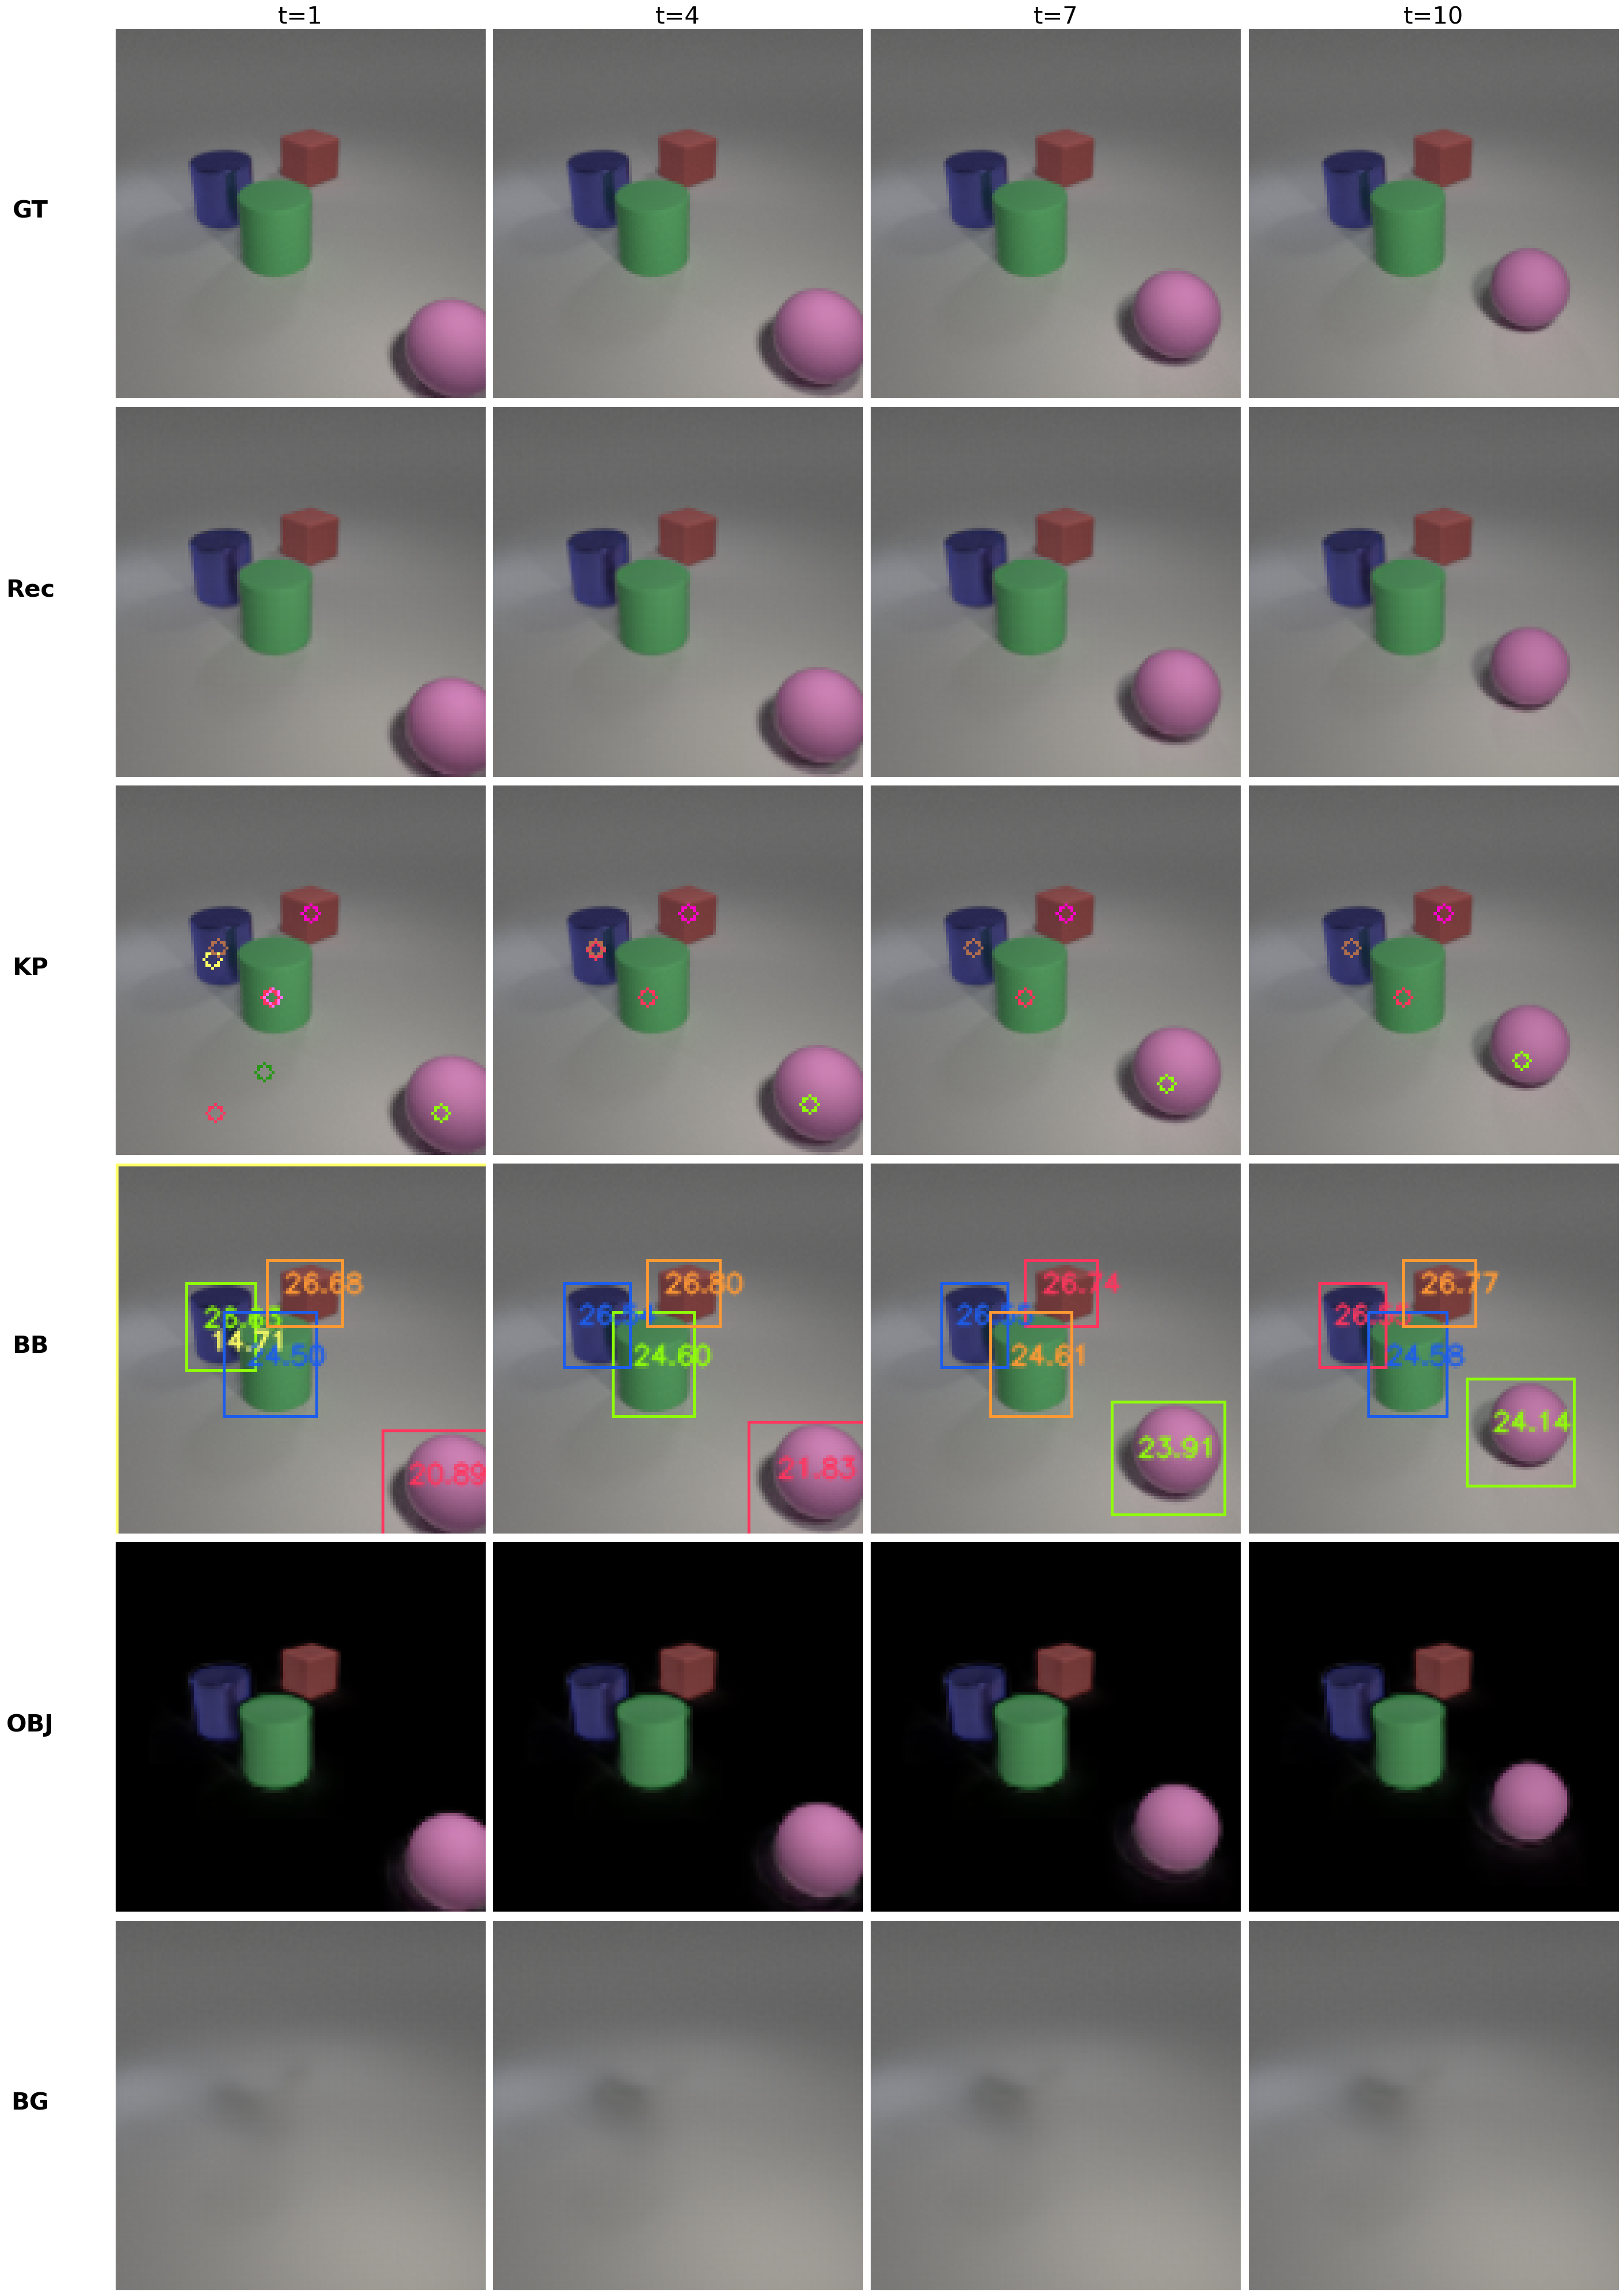

In [9]:
# plot - temporal [1, 40]
# [gt, rec, kp, bb, objects, bg]
batch_size = imgs.shape[0]
index = 0
times = (1, 4, 7, 10)

titles = ["GT", "Rec", "KP", "BB", "OBJ", "BG"]

gt = x.view(batch_size, -1, *x.shape[1:])
rec = rec_x.view(batch_size, -1, *rec_x.shape[1:])
img_kp = img_with_kp.view(batch_size, -1, *img_with_kp.shape[1:])
img_bb = img_with_masks_alpha_nms.view(batch_size, -1, *img_with_masks_alpha_nms.shape[1:])
img_obj = dec_objects.view(batch_size, -1, *dec_objects.shape[1:])
img_bg = bg.view(batch_size, -1, *bg.shape[1:])

plot_imgs = torch.stack([gt[index, times], rec[index, times], img_kp[index, times],
                        img_bb[index, times], img_obj[index, times], img_bg[index, times]], dim=0)

x_shift = -30
y_shift = 65
size = 30
align = 'center'
weight = 'bold'
title_size = 30
t = datetime.datetime.now().strftime("%d%m_%H%M")

fig = plt.figure(figsize=(28, 40))
plots_per_row = len(times)
for i in range(len(times)):
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, i + 1)
    ax.imshow(plot_imgs[0, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    ax.set_title(f't={times[i]}', fontsize=title_size)
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="GT", horizontalalignment=align, size=size, weight=weight)
    
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, plots_per_row + i + 1)
    ax.imshow(plot_imgs[1, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="Rec", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, 2 * plots_per_row + i + 1)
    ax.imshow(plot_imgs[2, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="KP", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, 3 * plots_per_row + i + 1)
    ax.imshow(plot_imgs[3, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="BB", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, 4 * plots_per_row + i + 1)
    ax.imshow(plot_imgs[4, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="OBJ", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(plot_imgs.shape[0], plots_per_row, 5 * plots_per_row + i + 1)
    ax.imshow(plot_imgs[5, i].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="BG", horizontalalignment=align, size=size, weight=weight)
    
plt.tight_layout()
# plt.savefig(f'./{ds}_{index}_{t}_ddlp_obj3d_att.png', dpi=300, bbox_inches="tight")

### <img src="https://img.icons8.com/dusk/64/future.png" style="height:50px;display:inline"> DDLP Inference - Video Prediction
---
* Let's use DDLP to predict the future frames of a video.

In [10]:
# generate
cond_steps = 10
generation_horizon = 100
with torch.no_grad():
    preds, z_preds = model.sample(imgs, num_steps=generation_horizon - cond_steps, deterministic=deterministic,
                         bg_masks_from_fg=False, cond_steps=cond_steps, return_z=True)
    # preds: [bs, timestep_horizon, 3, im_size, im_size]
    print(f'preds: {preds.shape}, z_pred: {list(z_preds.keys())}')

preds: torch.Size([1, 100, 3, 128, 128]), z_pred: ['z_pos', 'z_scale', 'z_obj_on', 'z_depth', 'z_features', 'z_bg_features', 'z_ids']


In [11]:
# view animation
index = 0
gt_gen_seq = torch.cat([imgs[index], preds[index]], dim=3)
plot_sequence_images(gt_gen_seq.permute(0, 2, 3, 1).data.cpu().numpy(), interval=50)

<Figure size 256x128 with 0 Axes>

In [ ]:
# optional - save animation
duration = 3 / 50  # fps
gt_traj = imgs[index].permute(0, 2, 3, 1).data.cpu().numpy()
pred_traj = preds[index].permute(0, 2, 3, 1).data.cpu().numpy()
pred_traj_2 = None
animate_trajectories(gt_traj, pred_traj, pred_trajectory_2=pred_traj_2,
                     path=f'./obj3d128_{t}_ddlp.gif',
                     duration=duration, rec_to_pred_t=cond_steps, title_1='DDLP-')

### <img src="https://img.icons8.com/external-smashingstocks-flat-smashing-stocks/66/external-Edit-design-and-creative-services-smashingstocks-flat-smashing-stocks-2.png" style="height:50px;display:inline"> DDLP Inference - Video Manipulation - What If...?
---
* Let's use DDLP to manipulate a video, asking "what if...?" questions.
* First, we need to get the IDs of the particles, so we can pick which ones we manipulate.

In [12]:
kp = z_preds['z_pos']
preds_wkp = plot_keypoints_on_image_batch(kp[index], preds[index], radius=3, thickness=1, max_imgs=150,
                                  kp_range=(-1, 1), plot_numbers=True)
print(f'preds_wkp: {preds_wkp.shape}')

preds_wkp: torch.Size([100, 3, 128, 128])


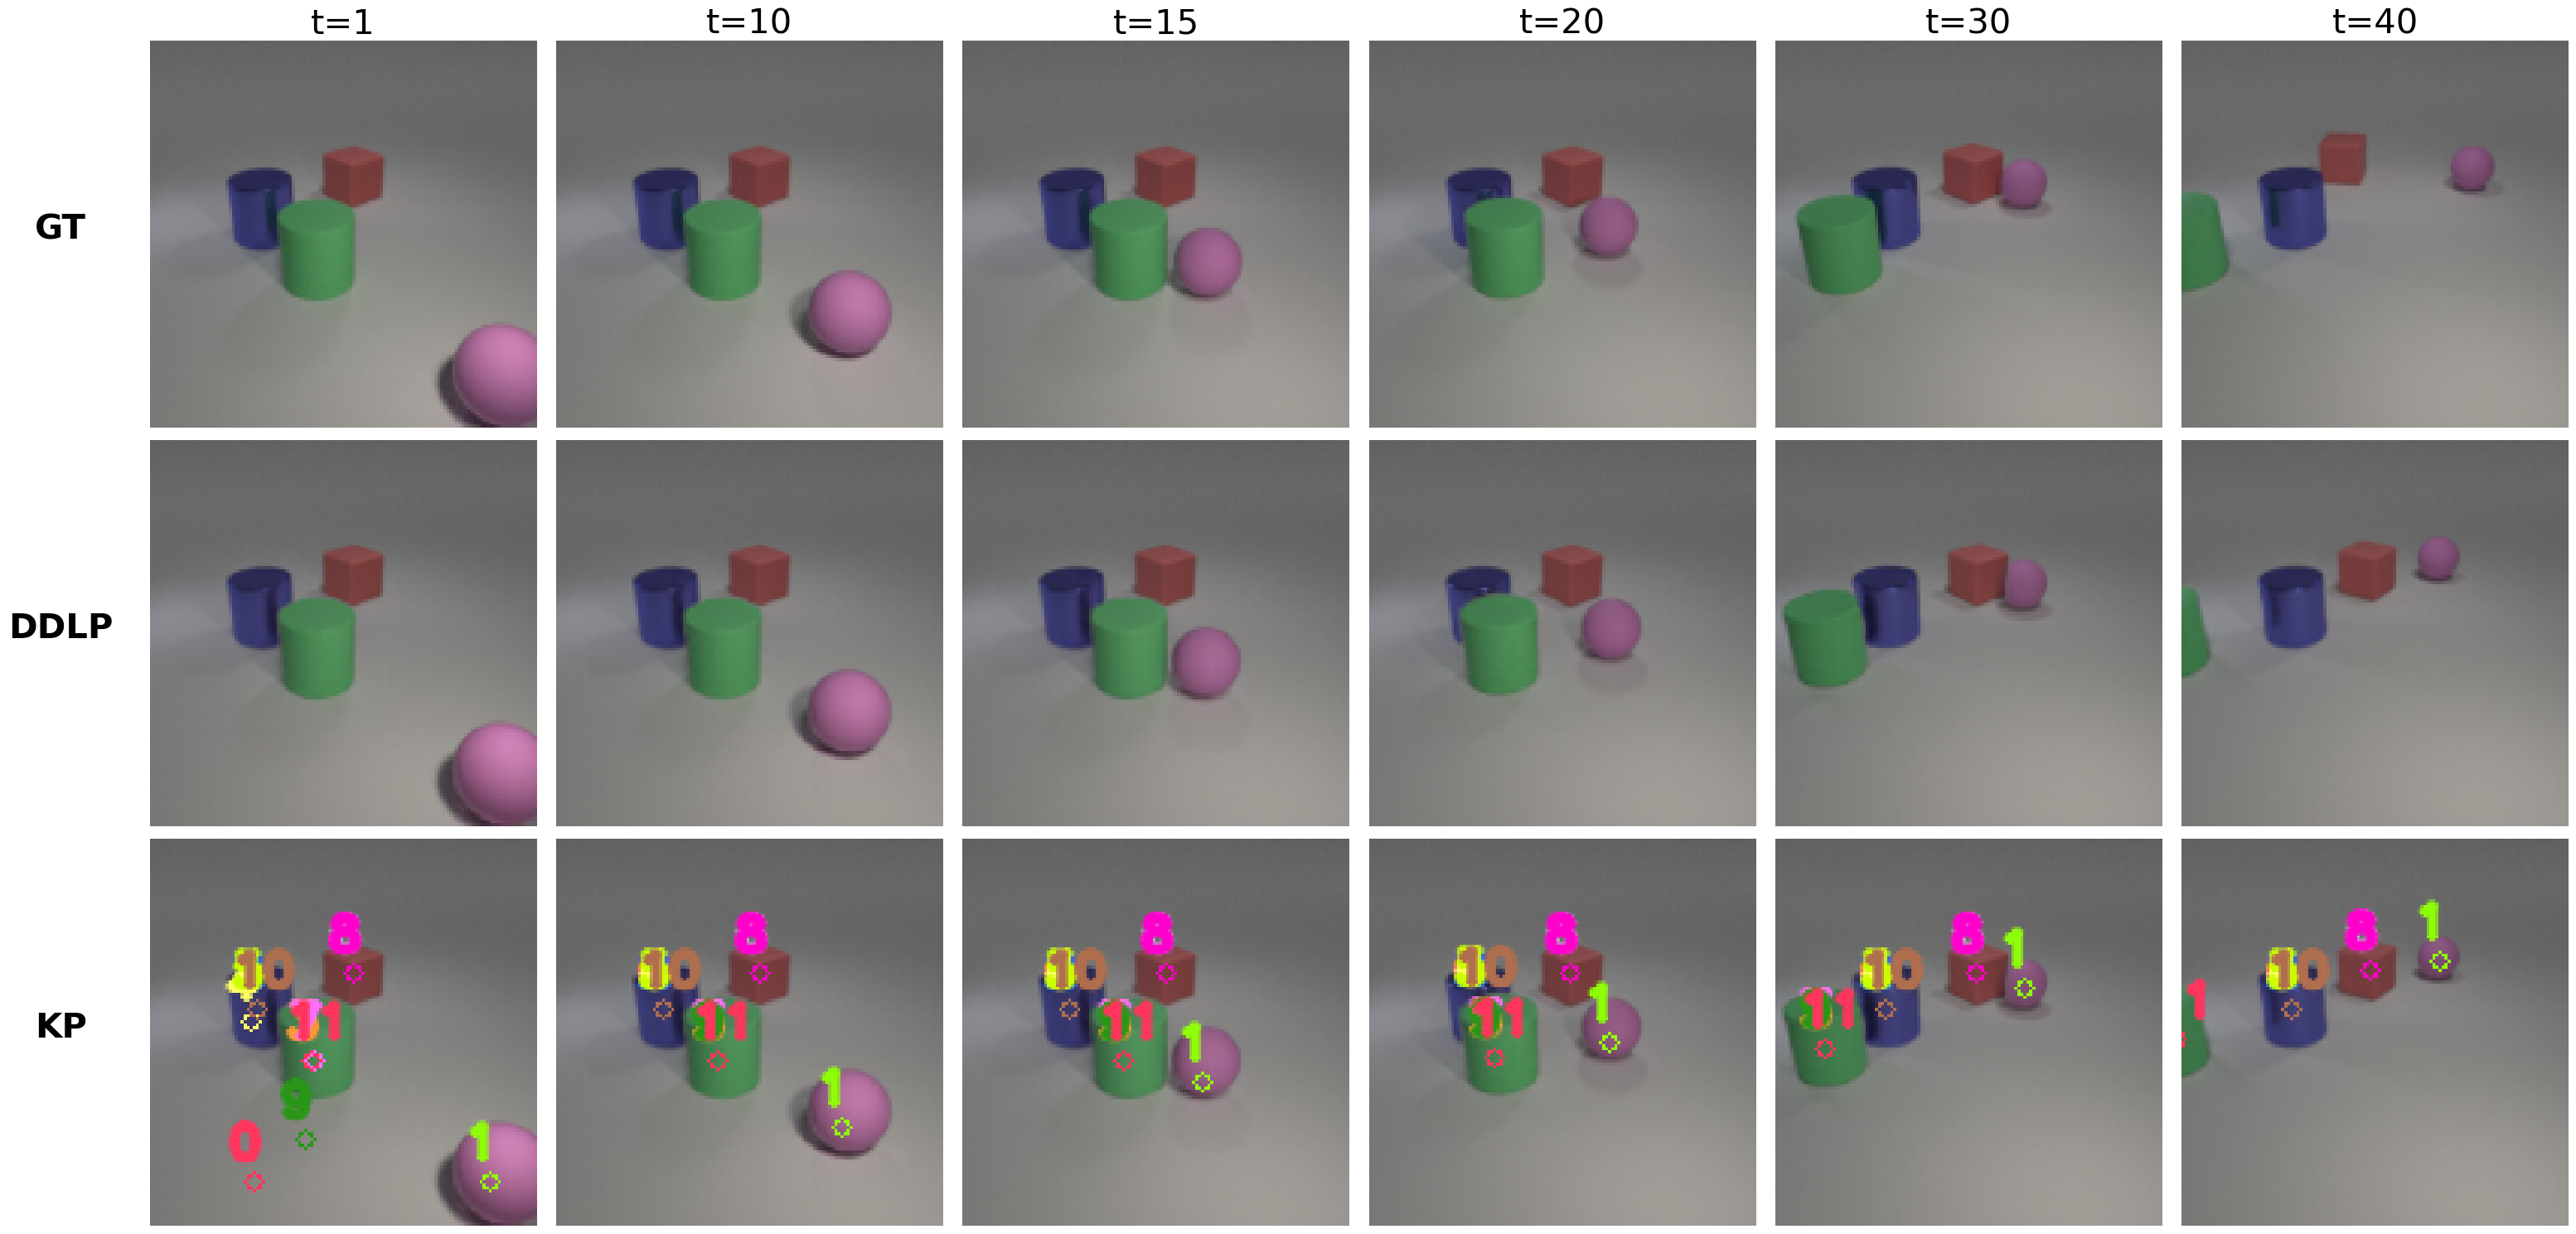

In [13]:
index = 0
times = (1, 10, 15, 20, 30, 40)

x_shift = -30
y_shift = 65
# size = 'xx-large'
size = 30
align = 'center'
weight = 'bold'
title_size = 30
t = datetime.datetime.now().strftime("%d%m_%H%M")

fig = plt.figure(figsize=(31, 15))
plots_per_row = len(times)
for i in range(len(times)):
    ax = fig.add_subplot(3, plots_per_row, i + 1)
    ax.imshow(imgs[index, times[i]].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    ax.set_title(f't={times[i]}', fontsize=title_size)
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="GT", horizontalalignment=align, size=size, weight=weight)
    
    ax = fig.add_subplot(3, plots_per_row, plots_per_row + i + 1)
    ax.imshow(preds[index, times[i]].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="DDLP", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(3, plots_per_row, 2 * plots_per_row + i + 1)
    ax.imshow(preds_wkp[times[i]].permute(1, 2, 0).data.cpu().numpy())
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="KP", horizontalalignment=align, size=size, weight=weight)
    
plt.tight_layout()

In [14]:
# playin in the latent space
# print positions in t = 10 
print(f'{z_preds["z_pos"][index, 10]}')

tensor([[-0.1117, -0.4416],
        [ 0.5038,  0.4833],
        [-0.1118, -0.4417],
        [ 0.1429, -0.1641],
        [-0.1118, -0.4416],
        [-0.1118, -0.4417],
        [-0.3031,  0.0490],
        [ 0.1429, -0.1641],
        [-0.3031,  0.0490],
        [ 0.1429, -0.1641],
        [-0.1118, -0.4417],
        [ 0.1429, -0.1641]])


In [15]:
# pink ball: 1
pink_ball_ind = [1,]
# green cylinder: 3, 7, 9, 11
green_cl_ind = [3, 7, 9 , 11]
# blue cylinder: 0, 2, 4, 5, 10
blue_cl_ind = [0, 2, 4, 5, 10]
# red cube: 6, 8
red_cube_ind = [6, 8]
# -------------------#
offset = torch.tensor([0.0, 0.15])
indices = pink_ball_ind
new_z_pos = z_preds["z_pos"][index, :cond_steps].clone()
new_z_pos[:, indices] = new_z_pos[:, indices] + offset
print(f'new_z_pos: {new_z_pos.shape}')

new_z_pos: torch.Size([10, 12, 2])


In [16]:
# unroll dynamics
z_v = new_z_pos.unsqueeze(0)
# z_v = z_preds['z_pos'][index, :cond_steps].unsqueeze(0)
z_scale_v = z_preds['z_scale'][index, :cond_steps].unsqueeze(0)
z_depth_v = z_preds['z_depth'][index, :cond_steps].unsqueeze(0)
z_obj_on_v = z_preds['z_obj_on'][index, :cond_steps].unsqueeze(0)
z_features_v = z_preds['z_features'][index, :cond_steps].unsqueeze(0)
z_bg_features_v = z_preds['z_bg_features'][index, :cond_steps].unsqueeze(0)

# dynamics
dyn_out = model.dyn_module.sample(z_v, z_scale_v, z_obj_on_v, z_depth_v, z_features_v, z_bg_features_v,
                                 steps=generation_horizon - cond_steps, deterministic=deterministic)
z_dyn, z_scale_dyn, z_obj_on_dyn, z_depth_dyn, z_features_dyn, z_bg_features_dyn = dyn_out



with torch.no_grad():
    z_dyn = z_dyn.reshape(-1, *z_dyn.shape[2:])
    z_features_dyn = z_features_dyn.reshape(-1, *z_features_dyn.shape[2:])
    z_bg_features_dyn = z_bg_features_dyn.reshape(-1, *z_bg_features_dyn.shape[2:])
    z_obj_on_dyn = z_obj_on_dyn.reshape(-1, *z_obj_on_dyn.shape[2:])
    z_depth_dyn = z_depth_dyn.reshape(-1, *z_depth_dyn.shape[2:])
    z_scale_dyn = z_scale_dyn.reshape(-1, *z_scale_dyn.shape[2:])
    dec_out = model.decode_all(z_dyn, z_features_dyn, z_bg_features_dyn, z_obj_on_dyn,
                              z_depth=z_depth_dyn, z_scale=z_scale_dyn)
rec_dyn = dec_out['rec']
rec_dyn = rec_dyn.reshape(1, -1, *rec_dyn.shape[1:])
print(f'rec_dyn: {rec_dyn.shape}')

rec_dyn: torch.Size([1, 100, 3, 128, 128])


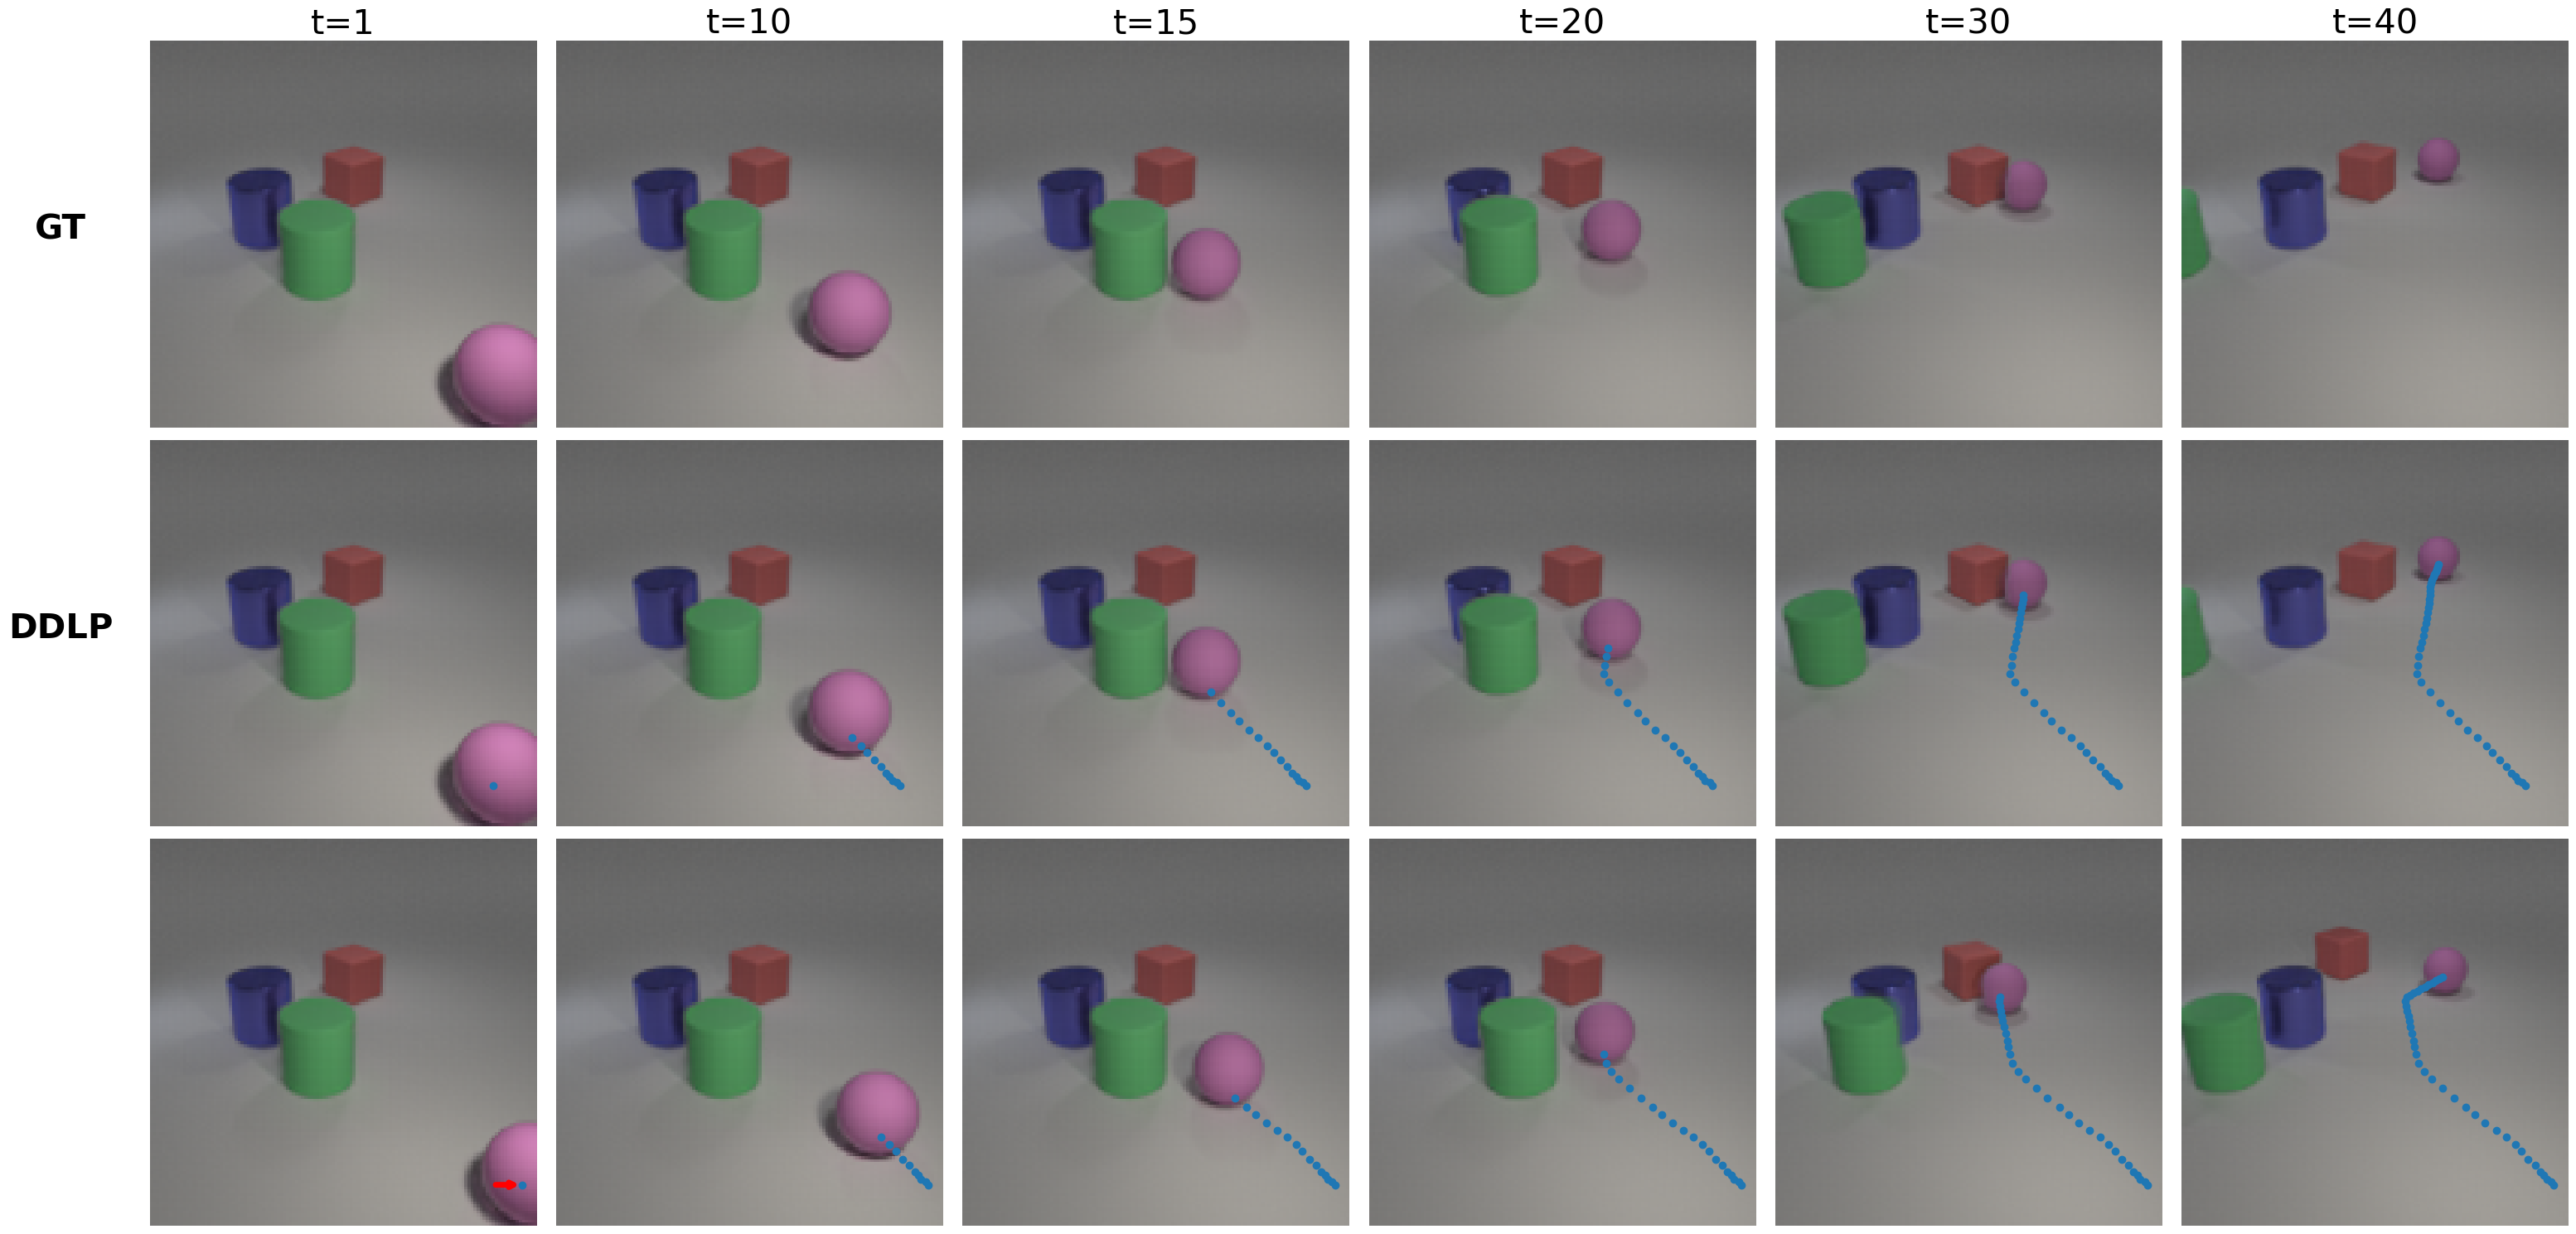

In [18]:
index = 0
times = (1, 10, 15, 20, 30, 40)

x_shift = -30
y_shift = 65
size = 30
align = 'center'
weight = 'bold'
title_size = 30
t = datetime.datetime.now().strftime("%d%m_%H%M")

fig = plt.figure(figsize=(31, 15))
plots_per_row = len(times)
for i in range(len(times)):
    ax = fig.add_subplot(3, plots_per_row, i + 1)
    ax.imshow(imgs[index, times[i]].permute(1, 2, 0).data.cpu().numpy())
    ax.imshow(preds[index, times[i]].permute(1, 2, 0).data.cpu().numpy())
    x_coor = 127 * (z.unsqueeze(0)[index, :times[i], indices, 1].data.cpu().numpy().flatten() + 1) / 2
    y_coor = 127 * (z.unsqueeze(0)[index, :times[i], indices, 0].data.cpu().numpy().flatten() + 1) / 2
#     ax.scatter(x_coor, y_coor)
    ax.set_axis_off()
    ax.set_title(f't={times[i]}', fontsize=title_size)
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="GT", horizontalalignment=align, size=size, weight=weight)
        x_0, y_0 = x_coor[0], y_coor[0]
    
    ax = fig.add_subplot(3, plots_per_row, plots_per_row + i + 1)
    ax.imshow(preds[index, times[i]].permute(1, 2, 0).data.cpu().numpy())
    x_coor = 127 * (z_preds['z_pos'][index, :times[i], indices, 1].data.cpu().numpy().flatten() + 1) / 2
    y_coor = 127 * (z_preds['z_pos'][index, :times[i], indices, 0].data.cpu().numpy().flatten() + 1) / 2
    ax.scatter(x_coor, y_coor)
    ax.set_axis_off()
    if i == 0:
        ax.text(x=x_shift, y=y_shift, s="DDLP", horizontalalignment=align, size=size, weight=weight)
        
    ax = fig.add_subplot(3, plots_per_row, 2 * plots_per_row + i + 1)
    ax.imshow(rec_dyn[0, times[i]].permute(1, 2, 0).data.cpu().numpy())
    x_coor = 127 * (z_dyn[:times[i], indices, 1].data.cpu().numpy().flatten() + 1) / 2
    y_coor = 127 * (z_dyn[:times[i], indices, 0].data.cpu().numpy().flatten() + 1) / 2
    ax.scatter(x_coor, y_coor)
    ax.set_axis_off()
    if i == 0:
        ax.annotate("", xy=(x_coor[0], y_coor[0]), xytext=(x_0, y_0), arrowprops=dict(arrowstyle="->", color='red', lw=5))
    
plt.tight_layout()

In [19]:
# view animation
gt_gen_seq = torch.cat([imgs[index], preds[index], rec_dyn[0]], dim=3)
plot_sequence_images(gt_gen_seq.permute(0, 2, 3, 1).data.cpu().numpy(), interval=50)

<Figure size 384x128 with 0 Axes>

In [ ]:
# save animation
duration = 3 / 50
max_vid_len = 60
gt_traj = imgs[index, :max_vid_len].permute(0, 2, 3, 1).data.cpu().numpy()
pred_traj = preds[index, :max_vid_len].permute(0, 2, 3, 1).data.cpu().numpy()
pred_traj_2 = rec_dyn[0, :max_vid_len].permute(0, 2, 3, 1).data.cpu().numpy()
title_text = "what if the pink ball started a little to the right?"
animate_trajectories(gt_traj, pred_traj, pred_trajectory_2=pred_traj_2,
                     path=f'./obj3d128_{t}_pball_little_right.gif',
                     duration=duration, rec_to_pred_t=cond_steps, title_1='DDLP-', title_2='MODIF-',
                     title_text=title_text)

## <img src="https://img.icons8.com/dusk/64/000000/prize.png" style="height:50px;display:inline"> Credits
---
* Icons from <a href="https://icons8.com/">Icon8.com</a> - https://icons8.com